# Result Table

In [6]:
import os
import sys
import h5py
import time
sys.path.append('utils')
import general
import datetime
import ipysheet
import numpy as np
from pandas import ExcelWriter


server_list = [
    'server_54',
    'server_58',
    'server_61',
    'server_62',
]
proj_name = os.path.basename(os.getcwd())

# 각 서버의 result_path들을 긁어모은다
remote_result_path_list = []
for server in server_list:
    result_dir_path = os.path.join('/home/juna', server, proj_name, 'result')
    if os.path.exists(result_dir_path):
        remote_result_path_list += [os.path.join(result_dir_path, path) for path in os.listdir(result_dir_path) if path[:1] == '2' or path[:4] == 'test']
    else:
        print('No such directory : {}'.format(result_dir_path))
        pass
# print('remote_result_path_list :', remote_result_path_list)

# 현재 서버의 result_path도 얻는다.
result_save_path = './result'
result_path_list = [os.path.join(result_save_path, path) for path in os.listdir(result_save_path) if path[:1] == '2' or path[:4] == 'test']

# 모든 서버의 result_path들에서 basename만 얻어낸다
result_path_basename_list = [os.path.basename(result_path) for result_path in result_path_list]
remote_result_path_basename_list = [os.path.basename(result_path) for result_path in remote_result_path_list]

# basename들에서 중복을 제거
all_result_path_basename_list = result_path_basename_list + remote_result_path_basename_list
all_result_path_basename_list_u = []
for basename in all_result_path_basename_list:
    if basename not in all_result_path_basename_list_u:
        all_result_path_basename_list_u.append(basename)

# 현재 서버나 원격 서버에 존재하는 특정 basename중에 수정시간이 늦은 것을 선택하여 사용
# print('all_result_path_basename_list_u :', all_result_path_basename_list_u)
# print('remote_result_path_list :', remote_result_path_list)
print()
result_path_list = []
result_dir_list_with_no_result_file = []
for basename in all_result_path_basename_list_u:

    result_path = None

    # 현재 서버에 basename이 존재하는지 체크하고 있으면 그것의 path와 수정시간을 기억
    curr_srv_result_path = None
    curr_srv_mtime = None
    if basename in result_path_basename_list:
        curr_srv_result_path = os.path.join('./result', basename)
        if os.path.exists(os.path.join('./result', basename, 'result.hdf5')):
            curr_srv_mtime = int(os.path.getmtime(os.path.join(curr_srv_result_path, 'result.hdf5')))
        

    # 원격 서버에 basename이 존재하는지 체크하고 있으면 그것의 path와 수정시간을 기억
    rmt_srv_result_path = None
    rmt_srv_mtime = None
    for path in remote_result_path_list:
        rmt_srv_result_path = path
        if basename in path and os.path.exists(os.path.join(path, 'result.hdf5')):
            rmt_srv_mtime = int(os.path.getmtime(os.path.join(path, 'result.hdf5')))
            break
    
    # 현재 서버 원격 서버에 모두 basename이 존재하면 수정 시간이 늦은 것을 사용
    if curr_srv_mtime is not None and rmt_srv_mtime is not None:
        if curr_srv_mtime == rmt_srv_mtime:
            result_path_list.append(curr_srv_result_path)
        elif curr_srv_mtime < rmt_srv_mtime:
            result_path_list.append(rmt_srv_result_path)
        else:
            raise Exception('curr_srv_mtime > rmt_srv_mtime, the result.hdf5 in {} might be modified which should not be'.format(curr_srv_result_path))
    elif curr_srv_mtime is not None and rmt_srv_mtime is None:
        result_path_list.append(curr_srv_result_path)
    elif curr_srv_mtime is None and rmt_srv_mtime is not None:
        result_path_list.append(rmt_srv_result_path)
    else:
        # 잘 따져보면 여기까지 오는 경우는 현재 서버, 원격 서버 모두 혹은 하나에 result.hdf5가 없는 result dir만 존재하는 경우다.
        # 이럴 땐 원격 서버에 그 result dir가 있으면 원격 서버 경로를 없으면 현재 서버 경로를 넣어준다.
        result_dir_list_with_no_result_file.append(basename)
        if basename in result_path_basename_list:
            result_path_list.append(os.path.join('./result', basename))
        else:
            for path in remote_result_path_list:
                if basename in path:
                    result_path_list.append(path)
                    break

print('List of result dir without result.hdf5')
for result_dir in result_dir_list_with_no_result_file:
    print(result_dir)
                

# path = './result'
# result_path_list = [os.path.join(path, path) for path in os.listdir(path) if path[:1] == '2']
result_path_list.sort()
# print('result_path_list :', result_path_list)
for result_path in result_path_list: 
    # result.hdf5의 마지막 수정일 구하기
    mod_time = None
    if os.path.exists(os.path.join(result_path, 'result.hdf5')):
        mtime = os.path.getmtime(os.path.join(result_path, 'result.hdf5'))
        mtime = datetime.datetime.fromtimestamp(mtime)
        ctime = datetime.datetime.now()
        time_diff = ctime - mtime
        mod_time = str(time_diff)[:-7] + ' ago'
        
#         setting_dict = general.get_setting(result_path)
#         setting_dict['modified_time'] = [mod_time]
#         if 'mtime' in list(setting_dict.keys()):
#             mtime_old = setting_dict['mtime']
#         else:
#             setting_dict['modified_time'] = [mod_time]
#         general.write_setting(setting_dict, result_path)
        
#         if mtime_old == mtime

    else:
        mtime = '-'
        mod_time = '-'
    
    # 현재 epoch 구하기
    curr_epoch = None
    if os.path.exists(os.path.join(result_path, 'result.hdf5')):
        print('result_path :', result_path)
        # 학습 도중에 epoch마다 알고리즘이 기록할 때 hdf5파일을 읽으려고 하면 에러뜨고 못 읽음 그럴 땐 연달아 10번 시도
        for trial in range(10):
            try:
                with h5py.File(os.path.join(result_path, 'result.hdf5'), 'r') as f:
                    if 'val_accuracy' in list(f.keys()):
                        curr_epoch = str(f['val_accuracy'].shape[0])
                    else:
                        curr_epoch = '-'
            except OSError as err:
                print("OS error: {0}".format(err))
            else:
                break
        else:
            raise Exception('Failed all the attempts')
    else:
        curr_epoch = '-'
    
    # args.txt에 기록
    setting_dict = general.get_setting(result_path)
#     setting_dict['mtime'] = [str(mtime)]
    setting_dict['modified_time'] = [mod_time]
    setting_dict['curr_epoch'] = [curr_epoch]
    general.write_setting(setting_dict, result_path)
    

        

        
df = general.result2dataframe(result_path_list)
sample_cond = {
}
df = general.get_df_sample(df, sample_cond)
# priorities = ['model', 'dataset_np_seed', 'seed', 'trial', 'iter_for_mask', 'lr', 'lambda_for_final', 'gamma', 'eta', 'best_val_acc', 'best_val_auc', 'IoU', 'result_path', 'small_dataset', 'modified_time', 'mask_ratio', 'threshold', 'ip', 'gpu', 'curr_epoch', 'interpreter', 'lrp_target_layer', 'train_func', 'val_func', 'IoU_func', 'data_path', 'train_ratio', 'dataset_class', 'min_tumor_size', 'epochs', 'batch_size', 'model_path']
# priorities = ['model', 'optimizer', 'lr', 'lambda_for_final', 'gamma', 'best_val_acc', 'best_val_auc', 'IoU', 'threshold', 'result_path', 'small_dataset', 'ip', 'gpu', 'modified_time', 'curr_epoch', 'interpreter', 'lrp_target_layer', 'train_func', 'val_func', 'IoU_func', 'data_path', 'dataset_class', 'seed', 'seg_label']
# priorities = ['model', 'seed', 'trial', 'iter_for_mask', 'lr', 'lambda_for_final', 'gamma', 'eta', 'best_val_acc', 'best_val_auc', 'IoU', 'result_path', 'small_dataset', 'modified_time', 'target_layer', 'mask_ratio', 'threshold', 'interpreter', 'ip', 'gpu', 'curr_epoch', 'what_to_patch_on_train', 'what_to_patch_on_val', 'lrp_target_layer', 'train_func', 'val_func', 'IoU_func', 'data_path', 'train_ratio', 'dataset_class', 'min_tumor_size', 'epochs', 'batch_size', 'model_path', 'R_process']
# priorities = ['model', 'seed', 'trial', 'iter_for_mask', 'lr', 'lambda_for_final', 'gamma', 'eta', 'best_val_acc', 'best_val_auc', 'IoU', 'result_path', 'small_dataset', 'modified_time', 'mask_ratio', 'threshold', 'ip', 'gpu', 'curr_epoch', 'interpreter', 'what_to_patch_on_val', 'lrp_target_layer', 'train_func', 'val_func', 'IoU_func', 'data_path', 'train_ratio', 'dataset_class', 'min_tumor_size', 'epochs', 'batch_size', 'model_path']
# priorities = ['model', 'seed', 'trial', 'iter_for_mask', 'lr', 'lambda_for_final', 'gamma', 'eta', 'best_val_acc', 'best_val_auc', 'IoU_0.05', 'IoU_0.1', 'IoU_0.2', 'IoU_0.3', 'IoU_0.4', 'IoU_0.5', 'IoU_0.6', 'IoU_0.7', 'IoU_0.8', 'IoU_0.9', 'result_path', 'small_dataset', 'modified_time', 'target_layer', 'mask_ratio', 'threshold', 'interpreter', 'ip', 'gpu', 'curr_epoch', 'what_to_patch_on_train', 'what_to_patch_on_val', 'lrp_target_layer', 'train_func', 'val_func', 'IoU_func', 'data_path', 'train_ratio', 'dataset_class', 'min_tumor_size', 'epochs', 'batch_size', 'model_path', 'R_process']
priorities = ['model', 'dataset_np_seed', 'seed', 'trial', 'mask_ratio', 'lrp_target_layer', 'target_layer', 'lr', 'lambda_for_final', 'gamma', 'eta', 'best_val_acc', 'best_val_auc', 'IoU_0.05', 'IoU_0.1', 'IoU_0.2', 'IoU_0.3', 'IoU_0.4', 'IoU_0.5', 'IoU_0.6', 'IoU_0.7', 'IoU_0.8', 'IoU_0.9', 'result_path', 'small_dataset', 'modified_time', 'threshold', 'interpreter', 'ip', 'gpu', 'curr_epoch', 'what_to_patch_on_train', 'what_to_patch_on_val', 'train_func', 'val_func', 'IoU_func', 'data_path', 'train_ratio', 'dataset_class', 'min_tumor_size', 'epochs', 'batch_size', 'model_path', 'R_process']
df = general.dataframe_edit(df, priorities)
# df.sort_values(by=['result_path', 'trial', 'lr', 'lambda_for_final', 'epochs'], inplace=True)
# df.sort_values(by=['lr', 'lambda_for_final', 'gamma', 'trial'], inplace=True)

# writer = ExcelWriter('plot_result.xlsx')
# df.to_excel(writer,'Sheet1')
# writer.save()

# display(df)
# sheet = ipysheet.from_dataframe(df)
# display(sheet)



No such directory : /home/juna/server_54/project_rsrlrp_isic_2102250012/result
No such directory : /home/juna/server_58/project_rsrlrp_isic_2102250012/result

List of result dir without result.hdf5
result_path : ./result/2102250149-1_20210225103307220
result_path : ./result/2102250149-1_20210225113644056
result_path : ./result/2102250149-2_20210225103310278
result_path : ./result/2102250149-2_20210225113930564
result_path : ./result/2102250149-3_20210225103326783
result_path : ./result/2102250149-3_20210225115007576
result_path : ./result/2102250149-42_20210227132110551
result_path : ./result/2102250149-42_20210227143857889
result_path : ./result/2102250149-42_20210227164500903
result_path : ./result/2102250149-4_20210225103334163
result_path : ./result/2102250149-4_20210225113942887
result_path : ./result/2102250149-4_20210225124537869
result_path : ./result/2102250149-4_20210225134907891
result_path : ./result/2102250149-51_20210227132045167
result_path : ./result/2102250149-51_20210

result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2103060316-1_20210306142753234
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2103060316-1_20210306151547720
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2103060316-1_20210306160242635
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2103060316-1_20210306165008905
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2103060316-1_20210306173628607
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104171954-1_20210417202522166
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104171954-1_20210417211417815
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104171954-1_20210417220316640
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104171954-1_20210417225208132
result_path : /home/juna/server_61/project_rsrlrp_isic_210225001

result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104172206-1_20210419125352979
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104172305-1_20210418061327957
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104172305-1_20210418103631538
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104172305-1_20210418145512668
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104172305-1_20210418191631364
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104172305-1_20210418233902071
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104172305-1_20210419035935165
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104172305-1_20210419082039117
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104172305-1_20210419124137715
result_path : /home/juna/server_61/project_rsrlrp_isic_210225001

result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104180140-2_20210419203923243
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104180140-2_20210419212551523
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104180140-2_20210419221306592
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104180140-2_20210420222330993
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104180140-2_20210420230955248
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104180140-2_20210420235705872
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104180140-2_20210421004405914
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104180140-2_20210421013107172
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2104180140-2_20210421021814970
result_path : /home/juna/server_61/project_rsrlrp_isic_210225001

result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105041811-1_20210505035629621
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105041811-1_20210505061956158
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105041811-1_20210505084301731
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105041811-1_20210505110541907
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105041811-1_20210505132846437
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105041811-1_20210505155146552
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105041811-2_20210504182542681
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105041811-2_20210504204849923
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105041811-2_20210504231121880
result_path : /home/juna/server_61/project_rsrlrp_isic_210225001

result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105050118-1_20210505150409596
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105050118-1_20210505150539593
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105050118-1_20210505150709667
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105050118-1_20210505150841516
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105050118-1_20210505151012642
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105230125-1_20210523040452849
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105230125-1_20210523045123603
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105230125-1_20210523054329285
result_path : /home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105230125-1_20210523063008093
result_path : /home/juna/server_61/project_rsrlrp_isic_210225001

result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2102250336-1_20210225043256221
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2102250336-1_20210225052222443
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2102250336-1_20210225061255882
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2102250336-1_20210225070325602
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2102250336-1_20210225075302900
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2102250336-22_20210227134738291
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2102250336-22_20210227143701716
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2102250336-22_20210227152644166
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2102250336-2_20210225034413597
result_path : /home/juna/server_62/project_rsrlrp_isic_210225

result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2103101544-2_20210310205218682
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2103101544-2_20210310212213582
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2103101544-2_20210310215138199
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2103101544-2_20210310222127398
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2103101544-2_20210310225023345
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172027-1_20210417203344143
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172027-1_20210417212607452
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172027-1_20210417221410363
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172027-1_20210417225944112
result_path : /home/juna/server_62/project_rsrlrp_isic_210225001

result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-1_20210422003110893
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-1_20210422014634130
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-1_20210422030120822
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-1_20210422041555545
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-1_20210422053204120
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-1_20210422064759341
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-1_20210422080338650
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-1_20210422091918955
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-1_20210422103423361
result_path : /home/juna/server_62/project_rsrlrp_isic_210225001

result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-3_20210418193603651
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-3_20210418205645035
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-3_20210418221744462
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-3_20210418233816870
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-3_20210419005947892
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-3_20210419022110741
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-3_20210419034224780
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-3_20210419050341365
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104172331-3_20210419062434874
result_path : /home/juna/server_62/project_rsrlrp_isic_210225001

result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104180140-4_20210422002930090
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2104180140-4_20210422011647429
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105041406-1_20210504142239141
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105041406-1_20210504164720218
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105041406-1_20210504191159082
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105041406-1_20210504213619632
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105041406-1_20210505000045593
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105041406-1_20210505022506577
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105041406-1_20210505044919088
result_path : /home/juna/server_62/project_rsrlrp_isic_210225001

result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-1_20210506150216809
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-1_20210506150349868
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-1_20210506150523553
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-1_20210506150701456
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-1_20210506150811110
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-1_20210506150921521
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-1_20210506151032639
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-1_20210506151142280
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-1_20210506151251471
result_path : /home/juna/server_62/project_rsrlrp_isic_210225001

result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-3_20210506153724841
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-3_20210506153934707
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-4_20210506154615310
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-4_20210506154717883
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-4_20210506154821948
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-4_20210506154929185
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-4_20210506155032823
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-4_20210506155139296
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105061407-4_20210506155243323
result_path : /home/juna/server_62/project_rsrlrp_isic_210225001

result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/test1_20210313200033883
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/test1_20210313205514496
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/test1_20210313214949798
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/test1_20210313224429349
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/test1_20210313233905354
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/test1_20210314003355202
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/test1_20210314012843239
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/test1_20210314022331540
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/test1_20210314031821852
result_path : /home/juna/server_62/project_rsrlrp_isic_2102250012/result/test1_20210314041307819
result_path : /home/juna/serve

In [7]:
def remove_front_str(x):
    if x[:7] == 'result/':
        return x[7:]
    return x

df['result_path'] = df['result_path'].apply(remove_front_str)
df.sort_values(by=['mask_ratio', 'lr', 'lambda_for_final', 'dataset_np_seed', 'seed', 'trial'], inplace=True) # 일반 dataset 실험
# df.sort_values(by=['interpreter', 'seed', 'trial', 'mask_ratio', 'lr', 'lambda_for_final', 'dataset_np_seed'], inplace=True) # 일반 dataset 실험
# df.sort_values(by=['R_process', 'mask_ratio', 'lr', 'lambda_for_final', 'dataset_np_seed', 'seed', 'trial'], inplace=True) # 일반 dataset 실험
filename = '2104290214-' # 2102220147-1
sheet = ipysheet.from_dataframe(df[df['result_path'].str.contains(filename)])
display(sheet)



Sheet(cells=(Cell(column_end=0, column_start=0, numeric_format=None, row_end=29, row_start=0, squeeze_row=Fals…

# 서버에 있는 모든 result 결과 보기

In [ ]:
def remove_front_str(x):
    if x[:7] == 'result/':
        return x[7:]
    return x

df['result_path'] = df['result_path'].apply(remove_front_str)
df.sort_values(by=['result_path', 'trial', 'lr', 'lambda_for_final', 'epochs'], inplace=True)
server_ip = '115.145.135.61'
sheet = ipysheet.from_dataframe(df[df['ip'].str.contains(server_ip)])
display(sheet)

# 서버에 있는 모든 model파일이 존재하는 result dir 보기

In [5]:
def remove_front_str(x):
    if x[:7] == 'result/':
        return x[7:]
    return x

df['result_path'] = df['result_path'].apply(remove_front_str)
df.sort_values(by=['result_path', 'trial', 'lr', 'lambda_for_final', 'epochs'], inplace=True)
server_ip = '115.145.135.61'

proj_name = os.path.basename(os.getcwd())
result_path_arr = np.array(df['result_path'])
model_exists = []
for result_dir in result_path_arr:
    if server_ip.split('.')[-1] == '59':
        model_path = os.path.join('/home/juna', proj_name, 'result', result_dir, 'model_best.pth.tar')    
    else:
        model_path = os.path.join('/home/juna', 
                                  'server_{}'.format(server_ip.split('.')[-1]),
                                  proj_name, 'result', result_dir, 'model_best.pth.tar')
    if os.path.exists(model_path):
        model_exists.append(True)
    else:
        model_exists.append(False)
model_exists = np.array(model_exists)
sheet = ipysheet.from_dataframe(df[model_exists])
display(sheet)

Sheet(cells=(Cell(column_end=0, column_start=0, numeric_format=None, row_end=186, row_start=0, squeeze_row=Fal…

# 모든 서버의 result.hdf5가 존재하는 result_dir 보기

In [ ]:
def remove_front_str(x):
    if x[:7] == 'result/':
        return x[7:]
    return x

df['result_path'] = df['result_path'].apply(remove_front_str)
df.sort_values(by=['result_path', 'trial', 'lr', 'lambda_for_final', 'epochs'], inplace=True)
server_list = [
    'server_54',
    'server_58',
    'server_61',
    'server_62',
]
proj_name = os.path.basename(os.getcwd())
result_path_arr = np.array(df['result_path'])
model_exists_cumul = np.zeros_like(result_path_arr)

for server in server_list:
    model_exists = []
    for result_dir in result_path_arr:
        if server == 'server_59':
            result_filepath = os.path.join('/home/juna', proj_name, 'result', result_dir, 'result.hdf5')
        else:
            result_filepath = os.path.join('/home/juna', server, proj_name, 'result', result_dir, 'result.hdf5')

        if os.path.exists(result_filepath):
            model_exists.append(True)
        else:
            model_exists.append(False)
            
    model_exists_cumul += np.array(model_exists)
    
sheet = ipysheet.from_dataframe(df[model_exists_cumul.astype(np.bool)])
display(sheet)

# 필요없는 모델 삭제

In [ ]:
import os
import sys
import h5py
sys.path.append('utils')
import general
import datetime
import ipysheet
from pandas import ExcelWriter


server_list = [
    'server_54',
    'server_58',
    'server_61',
    'server_62',
]
proj_name = os.path.basename(os.getcwd())

# 각 서버의 result_path들을 긁어모은다
remote_result_path_list = []
for server in server_list:
    result_dir_path = os.path.join('/home/juna', server, proj_name, 'result')
    if os.path.exists(result_dir_path):
        remote_result_path_list += [os.path.join(result_dir_path, path) for path in os.listdir(result_dir_path) if path[:1] == '2']
    else:
        print('No such directory : {}'.format(result_dir_path))
        pass
# print('remote_result_path_list :', remote_result_path_list)

# 현재 서버의 result_path도 얻는다.
result_save_path = './result'
result_path_list = [os.path.join(result_save_path, path) for path in os.listdir(result_save_path) if path[:1] == '2']


rem_list = [
'2102250305-1_20210225034522919',
'2102250305-1_20210225050429380',
'2102250305-1_20210225062323647',
'2102250305-1_20210225074132274',
'2102250305-1_20210225085844875',
'2102250305-1_20210225101729679',
'2102250305-2_20210225034524820',
'2102250305-2_20210225050451299',
'2102250305-2_20210225062403506',
'2102250305-2_20210225074315853',
]

confirm = False
total_result_path_list = result_path_list + remote_result_path_list
print()
print('Start removing')
for result_path in total_result_path_list:
#     print(result_path)
    if os.path.basename(result_path) in rem_list:
        if os.path.exists(os.path.join(result_path, 'model_best.pth.tar')):
            if not confirm:
                while True:
                    string = input('Are you sure to start removing?')
                    if string == 'y':
                        confirm = True
                        break
                    elif string == 'n':
                        confirm = False
                        break
                    else:
                        print('Type y or n')
                        continue
                if not confirm:
                    raise Exception('Canceled')
            print('{} removed'.format(os.path.join(result_path, 'model_best.pth.tar')))
            os.remove(os.path.join(result_path, 'model_best.pth.tar'))
        


# 모델만 다른 곳으로 옮기기

In [ ]:
import os
import sys
import h5py
sys.path.append('utils')
import general
import datetime
import ipysheet
from pandas import ExcelWriter
import distutils.dir_util

server_list = [
    'server_54',
    'server_58',
    'server_61',
    'server_62',
]
proj_name = os.path.basename(os.getcwd())

# 각 서버의 result_path들을 긁어모은다
remote_result_path_list = []
for server in server_list:
    result_dir_path = os.path.join('/home/juna', server, proj_name, 'result')
    if os.path.exists(result_dir_path):
        remote_result_path_list += [os.path.join(result_dir_path, path) for path in os.listdir(result_dir_path) if path[:1] == '2' or path[:4] == 'test']
    else:
        print('No such directory : {}'.format(result_dir_path))
        pass
# print('remote_result_path_list :', remote_result_path_list)

# 현재 서버의 result_path도 얻는다.
result_save_path = './result'
result_path_list = [os.path.join(result_save_path, path) for path in os.listdir(result_save_path) if path[:1] == '2' or path[:4] == 'test']

proj_name = 'project_rsrlrp_isic_2102250012'
mount_name = 'server_62_disk1'
rem_list = [

]

confirm = False
total_result_path_list = result_path_list + remote_result_path_list
print()
print('Start copying')
for result_path in total_result_path_list:
    if os.path.basename(result_path) in rem_list:
        if os.path.exists(os.path.join(result_path, 'model_best.pth.tar')):
            if not confirm:
                while True:
                    string = input('Are you sure to start copying?')
                    if string == 'y':
                        confirm = True
                        break
                    elif string == 'n':
                        confirm = False
                        break
                    else:
                        print('Type y or n')
                        continue
                if not confirm:
                    raise Exception('Canceled')
                    
            bound = result_path.find(proj_name)
            print('from :', result_path)
            print('to :', os.path.join('/home/juna', mount_name, 'juna', result_path[bound:]))
            
            try:
                distutils.dir_util.copy_tree(result_path, os.path.join('/home/juna', mount_name, 'juna', result_path[bound:]))
            except Exception as e: 
                print(e)
                raise Exception(e)
            print('{} removed'.format(os.path.join(result_path, 'model_best.pth.tar')))
            os.remove(os.path.join(result_path, 'model_best.pth.tar'))
        


# 필요없는 result dir 휴지통으로

In [8]:
import os
import sys
import h5py
import shutil
sys.path.append('utils')
import general
import datetime
import ipysheet
from pandas import ExcelWriter


server_list = [
    'server_54',
    'server_58',
    'server_61',
    'server_62',
]
proj_name = os.path.basename(os.getcwd())

# 각 서버의 result_path들을 긁어모은다
remote_result_path_list = []
for server in server_list:
    result_dir_path = os.path.join('/home/juna', server, proj_name, 'result')
    if os.path.exists(result_dir_path):
        remote_result_path_list += [os.path.join(result_dir_path, path) for path in os.listdir(result_dir_path) if path[:1] == '2']
    else:
        print('No such directory : {}'.format(result_dir_path))
        pass
# print('remote_result_path_list :', remote_result_path_list)

# 현재 서버의 result_path도 얻는다.
result_save_path = './result'
result_path_list = [os.path.join(result_save_path, path) for path in os.listdir(result_save_path) if path[:1] == '2']


rem_list = [
'2105230208-212_20210524042128500',
'2105230208-212_20210524042213674',
'2105230208-1_20210524014513420',
'2105230208-3_20210524011909315',
]

confirm = False
total_result_path_list = result_path_list + remote_result_path_list
print()
print('Start removing')
for result_path in total_result_path_list:
    if os.path.basename(result_path) in rem_list:
        if os.path.exists(result_path):
            if not confirm:
                while True:
                    string = input('Are you sure to start removing?')
                    if string == 'y':
                        confirm = True
                        break
                    elif string == 'n':
                        confirm = False
                        break
                    else:
                        print('Type y or n')
                        continue
                if not confirm:
                    raise Exception('Canceled')
            print('{} moved to trash'.format(result_path))
            if 'server_' in result_path:
                shutil.move(result_path, os.path.join('/', *result_path.split('/')[:4], '.local/share/Trash/files', os.path.basename(result_path)))
            else:
                shutil.move(result_path, os.path.join('/home/juna/.local/share/Trash/files', os.path.basename(result_path)))
        


No such directory : /home/juna/server_54/project_rsrlrp_isic_2102250012/result

Start removing
Are you sure to start removing?ㅛ
Type y or n
Are you sure to start removing?y
/home/juna/server_61/project_rsrlrp_isic_2102250012/result/2105230208-212_20210524042128500 moved to trash
/home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105230208-212_20210524042213674 moved to trash
/home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105230208-3_20210524011909315 moved to trash
/home/juna/server_62/project_rsrlrp_isic_2102250012/result/2105230208-1_20210524014513420 moved to trash


# ROC curve

In [ ]:
import os
import h5py
import shutil
import numpy as np
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
%matplotlib inline

import sys
sys.path.append('utils')
import general

server_list = [
    'server_54',
    'server_31',
    'server_58',
    'server_61',
]
proj_name = os.path.basename(os.getcwd())

# 각 서버의 result_path들을 긁어모은다
remote_result_path_list = []
for server in server_list:
    result_dir_path = os.path.join('/home/juna', server, proj_name, 'result')
    if os.path.exists(result_dir_path):
        remote_result_path_list += [os.path.join(result_dir_path, path) for path in os.listdir(result_dir_path) if path[:1] == '2']
    else:
        print('No such directory : {}'.format(result_dir_path))
        pass
# print('remote_result_path_list :', remote_result_path_list)

# 현재 서버의 result_path도 얻는다.
path = './result'
result_path_list = [os.path.join(path, path) for path in os.listdir(path) if path[:1] == '2']

# 모든 서버의 result_path들에서 basename만 얻어낸다
result_path_basename_list = [os.path.basename(result_path) for result_path in result_path_list]
remote_result_path_basename_list = [os.path.basename(result_path) for result_path in remote_result_path_list]

# basename들에서 중복을 제거
all_result_path_basename_list = result_path_basename_list + remote_result_path_basename_list
all_result_path_basename_list_u = []
for basename in all_result_path_basename_list:
    if basename not in all_result_path_basename_list_u:
        all_result_path_basename_list_u.append(basename)

# 현재 서버에 존재하는 basename들은 현재 서버의 경로로 그렇지 않으면 존재하는 다른 서버의 경로로 지정해줌
# print('all_result_path_basename_list_u :', all_result_path_basename_list_u)
# print('remote_result_path_list :', remote_result_path_list)
print()
result_path_list = []
for basename in all_result_path_basename_list_u:
    if basename in result_path_basename_list:
        result_path_list.append(os.path.join('./result', basename))
    else:
#         print('remote basename :', basename)
        for path in remote_result_path_list:
            if basename in path:
                result_path_list.append(path)
                break
                
# path = './result'
# result_path_list = [os.path.join(path, path) for path in os.listdir(path) if path[:1] == '2']
result_path_list.sort()

# df = general.result2dataframe(result_path_list)

# priorities = ['gpu', 'lr', 'train_ratio', 'mask_ratio']
# df = general.dataframe_edit(df, priorities)
# df.sort_values(by=['result_path'], inplace=True)

font = {'size'   : 15}
matplotlib.rc('font', **font)

window = 1
display_epoch = 50
dirname_list = [
'2101150819-1_20210116205326799',
'2101150819-1_20210116223302876',
'2101150819-1_20210117001312821',
]
label_list = [
    
]
plot_list = ['train_class_loss', 'train_lrp_loss', 'train_accuracy', 'val_class_loss', 'val_lrp_loss', 'val_accuracy']
fig, ax = plt.subplots(nrows=1, ncols=len(plot_list), figsize=(len(plot_list)*6, 5))
for dirname in dirname_list:
    dir_path = None
    if dirname in result_path_basename_list:
        dir_path = os.path.join('./result', dirname)
    else:
#         print('remote dirname :', dirname)
        for remote_result_path in remote_result_path_list:
            if dirname in remote_result_path:
                dir_path = remote_result_path
                break
    
    
    shutil.copyfile(os.path.join(dir_path, 'result.hdf5'), os.path.join(dir_path, 'result_copy.hdf5'))
    with h5py.File(os.path.join(dir_path, 'result_copy.hdf5'), 'r') as f:
        print(list(f.keys()))
        
        # 여기서부터 result_copy.hdf5 내용물로 하고 싶은거 하면 됨
        
        

plt.show()


# Learning Curve

No such directory : /home/juna/server_54/project_rsrlrp_isic_2102250012/result

['train_accuracy', 'train_auc', 'train_class_loss', 'train_loss', 'train_lrp_loss', 'val_accuracy', 'val_auc', 'val_class_loss', 'val_loss', 'val_lrp_loss']
['train_accuracy', 'train_auc', 'train_class_loss', 'train_loss', 'train_lrp_loss', 'val_accuracy', 'val_auc', 'val_class_loss', 'val_loss', 'val_lrp_loss']
['train_accuracy', 'train_auc', 'train_class_loss', 'train_loss', 'train_lrp_loss', 'val_accuracy', 'val_auc', 'val_class_loss', 'val_loss', 'val_lrp_loss']


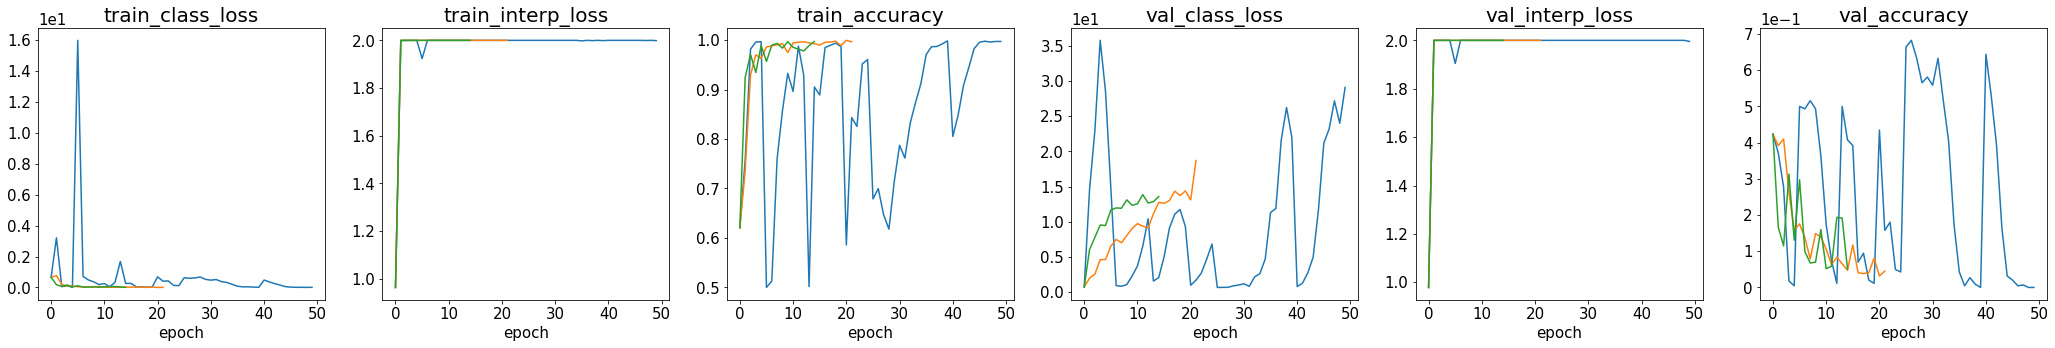

In [3]:
import os
import h5py
import shutil
import numpy as np
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
%matplotlib inline

import sys
sys.path.append('utils')
import general

server_list = [
    'server_54',
    'server_58',
    'server_61',
    'server_62',
]
proj_name = os.path.basename(os.getcwd())

# 각 서버의 result_path들을 긁어모은다
remote_result_path_list = []
for server in server_list:
    result_dir_path = os.path.join('/home/juna', server, proj_name, 'result')
    if os.path.exists(result_dir_path):
        remote_result_path_list += [os.path.join(result_dir_path, path) for path in os.listdir(result_dir_path) if path[:1] == '2']
    else:
        print('No such directory : {}'.format(result_dir_path))
        pass
# print('remote_result_path_list :', remote_result_path_list)

# 현재 서버의 result_path도 얻는다.
path = './result'
result_path_list = [os.path.join(path, path) for path in os.listdir(path) if path[:1] == '2']

# 모든 서버의 result_path들에서 basename만 얻어낸다
result_path_basename_list = [os.path.basename(result_path) for result_path in result_path_list]
remote_result_path_basename_list = [os.path.basename(result_path) for result_path in remote_result_path_list]

# basename들에서 중복을 제거
all_result_path_basename_list = result_path_basename_list + remote_result_path_basename_list
all_result_path_basename_list_u = []
for basename in all_result_path_basename_list:
    if basename not in all_result_path_basename_list_u:
        all_result_path_basename_list_u.append(basename)

# 현재 서버에 존재하는 basename들은 현재 서버의 경로로 그렇지 않으면 존재하는 다른 서버의 경로로 지정해줌
# print('all_result_path_basename_list_u :', all_result_path_basename_list_u)
# print('remote_result_path_list :', remote_result_path_list)
print()
result_path_list = []
for basename in all_result_path_basename_list_u:
    if basename in result_path_basename_list:
        result_path_list.append(os.path.join('./result', basename))
    else:
#         print('remote basename :', basename)
        for path in remote_result_path_list:
            if basename in path:
                result_path_list.append(path)
                break
                
# path = './result'
# result_path_list = [os.path.join(path, path) for path in os.listdir(path) if path[:1] == '2']
result_path_list.sort()

# df = general.result2dataframe(result_path_list)

# priorities = ['gpu', 'lr', 'train_ratio', 'mask_ratio']
# df = general.dataframe_edit(df, priorities)
# df.sort_values(by=['result_path'], inplace=True)

font = {'size'   : 15}
matplotlib.rc('font', **font)

window = 1 # moving average
display_epoch = 50
dirname_list = [
'2105230208-2_20210523031246202',
'2105230208-2_20210524012726494',
'2105230208-22_20210524022829312',
]
label_list = [
#     'lr:1e-5 lam:1e+4',
#     'lr:1e-6 lam:1e+4',
#     'lr:5e-7 lam:1e+4',
]
assert len(label_list) == 0 or len(dirname_list) == len(label_list), 'length of dirname_list and label_list should be the same'
plot_list = ['train_class_loss', 'train_lrp_loss', 'train_accuracy', 'val_class_loss', 'val_lrp_loss', 'val_accuracy']
fig, ax = plt.subplots(nrows=1, ncols=len(plot_list), figsize=(len(plot_list)*6, 5))
for dir_num, dirname in enumerate(dirname_list):
    dir_path = None
    if dirname in result_path_basename_list:
        dir_path = os.path.join('./result', dirname)
    else:
#         print('remote dirname :', dirname)
        for remote_result_path in remote_result_path_list:
            if dirname in remote_result_path:
                dir_path = remote_result_path
                break
    
    
    shutil.copyfile(os.path.join(dir_path, 'result.hdf5'), os.path.join(dir_path, 'result_copy.hdf5'))
    with h5py.File(os.path.join(dir_path, 'result_copy.hdf5'), 'r') as f:
        print(list(f.keys()))
        
        y_dict = OrderedDict()
        min_length = 100000
        for y in plot_list:
            y_dict[y] = f[y][()]
#             print('{} : {}'.format(y, y_dict[y].shape))
            if y_dict[y].shape[0] < min_length:
                min_length = y_dict[y].shape[0]
                
        for y in plot_list:
            if display_epoch is not None and display_epoch < min_length:
                y_dict[y] = y_dict[y][:display_epoch]
            else:
                y_dict[y] = y_dict[y][:min_length]
#             print('{} : {}'.format(y, y_dict[y].shape))
        
        x = np.arange(min(y_dict['train_class_loss'].shape[0]-(window-1), display_epoch))

        for num, key in enumerate(list(y_dict.keys())):
            new_y = []
            for i in range(y_dict[key].shape[0]-(window-1)):
                new_y.append(y_dict[key][i:i+window].mean())
            y_dict[key] = np.array(new_y)
        
            if len(label_list) != 0:
                ax[num].plot(x, y_dict[key], label=label_list[dir_num])
                ax[num].legend(fontsize=12)
            else:
                ax[num].plot(x, y_dict[key])
            ax[num].set_title(key if 'lrp' not in key else 'interp'.join(key.split('lrp')), fontsize=20)
            ax[num].set_xlabel('epoch')
            ax[num].ticklabel_format(style='sci', axis='y', scilimits=(-2, -1))

plt.show()


# learning curve for HAM10000

In [ ]:
import os
import h5py
import shutil
import numpy as np
import pandas as pd
import ipysheet
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
%matplotlib inline

import sys
sys.path.append('utils')
import general

server_list = [
    'server_54',
    'server_58',
    'server_61',
    'server_62',
]
proj_name = os.path.basename(os.getcwd())

# 각 서버의 result_path들을 긁어모은다
remote_result_path_list = []
for server in server_list:
    result_dir_path = os.path.join('/home/juna', server, proj_name, 'result')
    if os.path.exists(result_dir_path):
        remote_result_path_list += [os.path.join(result_dir_path, path) for path in os.listdir(result_dir_path) if path[:1] == '2']
    else:
        print('No such directory : {}'.format(result_dir_path))
        pass
# print('remote_result_path_list :', remote_result_path_list)

# 현재 서버의 result_path도 얻는다.
path = './result'
result_path_list = [os.path.join(path, path) for path in os.listdir(path) if path[:1] == '2']

# 모든 서버의 result_path들에서 basename만 얻어낸다
result_path_basename_list = [os.path.basename(result_path) for result_path in result_path_list]
remote_result_path_basename_list = [os.path.basename(result_path) for result_path in remote_result_path_list]

# basename들에서 중복을 제거
all_result_path_basename_list = result_path_basename_list + remote_result_path_basename_list
all_result_path_basename_list_u = []
for basename in all_result_path_basename_list:
    if basename not in all_result_path_basename_list_u:
        all_result_path_basename_list_u.append(basename)

# 현재 서버에 존재하는 basename들은 현재 서버의 경로로 그렇지 않으면 존재하는 다른 서버의 경로로 지정해줌
# print('all_result_path_basename_list_u :', all_result_path_basename_list_u)
# print('remote_result_path_list :', remote_result_path_list)
print()
result_path_list = []
for basename in all_result_path_basename_list_u:
    if basename in result_path_basename_list:
        result_path_list.append(os.path.join('./result', basename))
    else:
#         print('remote basename :', basename)
        for path in remote_result_path_list:
            if basename in path:
                result_path_list.append(path)
                break
                
# path = './result'
# result_path_list = [os.path.join(path, path) for path in os.listdir(path) if path[:1] == '2']
result_path_list.sort()

# df = general.result2dataframe(result_path_list)

# priorities = ['gpu', 'lr', 'train_ratio', 'mask_ratio']
# df = general.dataframe_edit(df, priorities)
# df.sort_values(by=['result_path'], inplace=True)

font = {'size'   : 15}
matplotlib.rc('font', **font)

window = 1 # moving average
display_epoch = 50
dirname_list = [
#     '2103041906-1_20210306144731811',
# '2103041905-1_20210304194625393',
#     '2103041906-1_20210306150452502',
    
#     '2103060228-1_20210306034345372',
#     '2103060228-1_20210306040137058',
#     '2103060228-1_20210306041924320',
    
#     '2103060221-1_20210306142736856',
    
#     '2102250149-3_20210225103326783',
    
#     '2103060320-1_20210306070349859',
#     '2103060311-1_20210306113016404',
    
#     '2103091610-1_20210309174437044',
#     '2103060315-1_20210306061626740',
#     '2103060316-1_20210306142753234',
#     '2103060315-1_20210306074920619',
    
    '2102250336-2_20210225034413597',
#     '2102250336-2_20210225043111651',
]
label_list = [
# '100',
# '10000',
# '1000000',
]
assert len(label_list) == 0 or len(dirname_list) == len(label_list), 'length of dirname_list and label_list should be the same'
plot_list = ['train_loss', 'train_class_loss', 'train_lrp_loss', 'train_accuracy', 'val_loss', 'val_class_loss', 'val_lrp_loss', 'val_accuracy']

max_valid_val_acc_list = []
fig, ax = plt.subplots(nrows=1, ncols=len(plot_list)+1, figsize=(len(plot_list)*6, 5))
for dir_num, dirname in enumerate(dirname_list):
    dir_path = None
    if dirname in result_path_basename_list:
        dir_path = os.path.join('./result', dirname)
    else:
#         print('remote dirname :', dirname)
        for remote_result_path in remote_result_path_list:
            if dirname in remote_result_path:
                dir_path = remote_result_path
                break
    
    
    shutil.copyfile(os.path.join(dir_path, 'result.hdf5'), os.path.join(dir_path, 'result_copy.hdf5'))
    with h5py.File(os.path.join(dir_path, 'result_copy.hdf5'), 'r') as f:
        print(list(f.keys()))
        
        y_dict = OrderedDict()
        min_length = 100000
        for y in plot_list:
            y_dict[y] = f[y][()]
#             print('{} : {}'.format(y, y_dict[y].shape))
            if y_dict[y].shape[0] < min_length:
                min_length = y_dict[y].shape[0]
                
        for y in plot_list:
            if display_epoch is not None and display_epoch < min_length:
                y_dict[y] = y_dict[y][:display_epoch]
            else:
                y_dict[y] = y_dict[y][:min_length]
#             print('{} : {}'.format(y, y_dict[y].shape))
        
        x = np.arange(min(y_dict['train_class_loss'].shape[0]-(window-1), display_epoch))

        for num, key in enumerate(list(y_dict.keys())):
            new_y = []
            for i in range(y_dict[key].shape[0]-(window-1)):
                new_y.append(y_dict[key][i:i+window].mean())
            y_dict[key] = np.array(new_y)
        
            if len(label_list) != 0:
                ax[num].plot(x, y_dict[key], label=label_list[dir_num])
                ax[num].legend(fontsize=12)
            else:
                ax[num].plot(x, y_dict[key])
            ax[num].set_title(key if 'lrp' not in key else 'interp'.join(key.split('lrp')), fontsize=20)
            ax[num].set_xlabel('epoch')
            ax[num].ticklabel_format(style='sci', axis='y', scilimits=(-2, -1))
            
#         print('list(y_dict.keys()) :', list(y_dict.keys()))
        x = np.arange(y_dict['train_accuracy'].shape[0])
        
        filter = (y_dict['train_accuracy'] > y_dict['val_accuracy']).astype(np.bool)
        new_x_valid = x[filter]
        valid_val_acc_valid = y_dict[key][filter]
        ax[-1].scatter(new_x_valid, valid_val_acc_valid)
        
        filter = (y_dict['train_accuracy'] <= y_dict['val_accuracy']).astype(np.bool)
        new_x = x[filter]
        valid_val_acc = y_dict[key][filter]
        ax[-1].scatter(new_x, valid_val_acc)
        
        ax[-1].set_title('valid val_accuracy', fontsize=20)
        ax[-1].set_xlabel('epoch')
        ax[-1].ticklabel_format(style='sci', axis='y', scilimits=(-2, -1))
        
        if valid_val_acc_valid.shape[0] == 0:
            print('There is no valid val accuracy')
        else:
            max_valid_val_acc_list.append(np.round(valid_val_acc_valid.max(), 3))
#         print('max valid val_acc :', np.round(valid_val_acc_valid.max(), 3))
        
plt.show()

if len(max_valid_val_acc_list) == 0:
    pass
else:
    sheet = ipysheet.from_dataframe(pd.DataFrame({'max_valid_val_acc' : np.array(max_valid_val_acc_list)}))
    display(sheet)


# Interpretation

No such directory : /home/juna/server_54/project_rsrlrp_isic_2102250012/result
No such directory : /home/juna/server_58/project_rsrlrp_isic_2102250012/result

['false_neg', 'false_pos', 'true_neg', 'true_pos']
true_pos :
[8, 11, 15, 19, 23, 24, 27, 37, 41, 42, 43, 47, 51, 52, 60, 62, 66, 67, 70, 72, 76, 80, 82, 88, 92, 95, 99, 100, 104, 107, 114, 116, 117, 122, 143, 144, 145, 148, 150, 152, 153, 154, 155, 165, 166, 167, 175, 178, 184, 187]
false_neg :
[4, 6, 16, 31, 32, 35, 36, 38, 39, 40, 50, 53, 58, 59, 61, 69, 71, 77, 79, 83, 84, 87, 96, 98, 103, 106, 110, 115, 119, 123, 124, 125, 126, 134, 139, 141, 146, 147, 151, 158, 168, 170, 183, 192, 194, 195, 203, 208, 209, 215]
true_neg :
[0, 7, 10, 12, 13, 14, 17, 18, 21, 25, 28, 29, 30, 34, 46, 49, 54, 55, 64, 73, 74, 75, 78, 81, 85, 86, 89, 91, 93, 97, 101, 109, 112, 113, 118, 120, 128, 129, 130, 131, 132, 133, 135, 136, 140, 149, 156, 159, 160, 161, 162]
false_pos :
[1, 2, 3, 5, 9, 20, 22, 26, 33, 44, 45, 48, 56, 57, 63, 65, 68, 90, 94, 

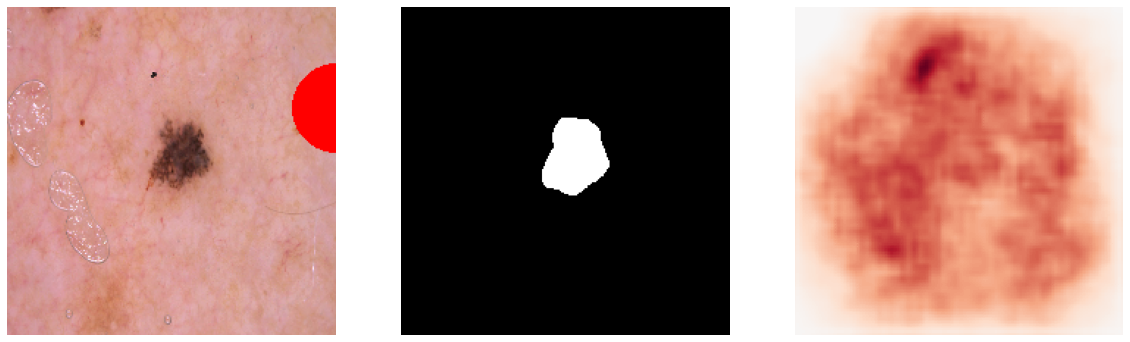

['false_neg', 'false_pos', 'true_neg', 'true_pos']
true_pos :
[4, 8, 11, 15, 19, 27, 35, 37, 38, 41, 43, 47, 53, 61, 66, 67, 76, 79, 83, 88, 92, 95, 96, 98, 99, 100, 103, 104, 107, 114, 115, 116, 117, 122, 123, 124, 134, 141, 143, 145, 150, 151, 152, 153, 154, 158, 165, 167, 183, 184]
false_neg :
[6, 16, 23, 24, 31, 32, 36, 39, 40, 42, 50, 51, 52, 58, 59, 60, 62, 69, 70, 71, 72, 77, 80, 82, 84, 87, 106, 110, 119, 125, 126, 139, 144, 146, 147, 148, 155, 166, 168, 170, 175, 178, 187, 196, 199, 207, 209, 211, 215, 222]
true_neg :
[1, 3, 7, 9, 10, 13, 14, 17, 18, 20, 21, 25, 26, 28, 29, 30, 33, 44, 45, 46, 48, 49, 54, 56, 64, 68, 73, 74, 81, 85, 89, 91, 93, 97, 101, 102, 111, 112, 118, 121, 128, 130, 131, 132, 133, 135, 136, 142, 149, 156]
false_pos :
[0, 2, 5, 12, 22, 34, 55, 57, 63, 65, 75, 78, 86, 90, 94, 105, 108, 109, 113, 120, 127, 129, 137, 138, 140, 157, 159, 172, 176, 177, 181, 186, 189, 191, 201, 204, 210, 213, 216, 217, 233, 234, 245, 248, 258, 259, 288, 290, 300, 303]

########

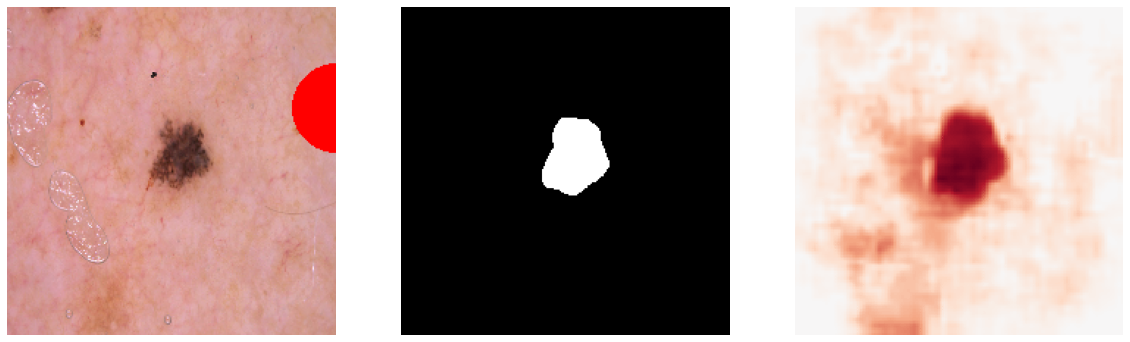

['false_neg', 'false_pos', 'true_neg', 'true_pos']
true_pos :
[8, 11, 19, 37, 38, 40, 42, 47, 51, 60, 62, 67, 70, 72, 76, 77, 82, 87, 95, 100, 104, 107, 110, 114, 116, 122, 123, 124, 145, 150, 155, 158, 166, 167, 178, 183, 187, 193, 195, 196, 197, 203, 207, 208, 226, 228, 236, 238, 239, 241, 242, 247]
false_neg :
[4, 6, 15, 16, 23, 24, 27, 31, 32, 35, 36, 39, 41, 43, 50, 52, 53, 58, 59, 61, 66, 69, 71, 79, 80, 83, 84, 88, 92, 96, 98, 99, 103, 106, 115, 117, 119, 125, 126, 134, 139, 141, 143, 144, 146, 147, 148, 151, 152, 153, 154]
true_neg :
[0, 5, 7, 10, 12, 13, 14, 17, 21, 25, 28, 29, 30, 33, 34, 46, 48, 49, 54, 55, 57, 73, 74, 75, 78, 81, 86, 89, 91, 93, 97, 101, 109, 112, 118, 120, 121, 128, 129, 130, 131, 132, 133, 136, 140, 142, 149, 156, 159, 162]
false_pos :
[1, 2, 3, 9, 18, 20, 22, 26, 44, 45, 56, 63, 64, 65, 68, 85, 90, 94, 102, 105, 108, 111, 113, 127, 135, 137, 138, 157, 160, 161, 163, 164, 171, 176, 177, 182, 185, 188, 189, 190, 198, 200, 202, 205, 212, 213, 217, 221, 232,

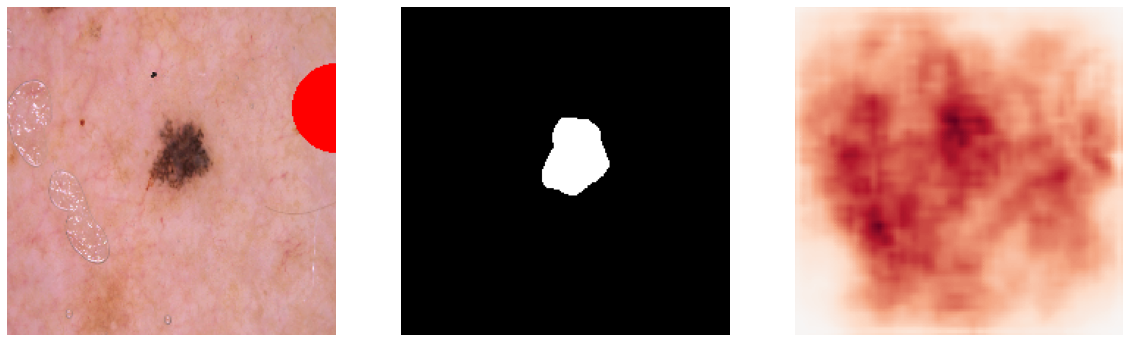

['false_neg', 'false_pos', 'true_neg', 'true_pos']
true_pos :
[4, 8, 11, 15, 24, 27, 31, 32, 37, 38, 39, 40, 41, 42, 43, 47, 51, 52, 53, 58, 59, 61, 62, 66, 67, 70, 76, 77, 80, 82, 84, 88, 92, 95, 96, 99, 100, 103, 106, 107, 110, 115, 116, 117, 122, 123, 124, 125, 134, 141, 143]
false_neg :
[6, 16, 19, 23, 35, 36, 50, 60, 69, 71, 72, 79, 83, 87, 98, 104, 114, 119, 126, 139, 152, 158, 170, 193, 199, 209, 219, 231, 237, 240, 251, 254, 263, 266, 271, 273, 283, 293, 319, 321, 322, 335, 342, 343, 348, 367, 370, 374, 382, 384, 391]
true_neg :
[1, 3, 5, 7, 9, 10, 12, 13, 17, 18, 21, 22, 25, 26, 28, 29, 30, 33, 44, 45, 46, 48, 49, 54, 55, 63, 68, 73, 74, 75, 78, 81, 85, 86, 89, 91, 93, 97, 101, 102, 105, 109, 112, 113, 118, 120, 121, 128, 129, 130, 131, 132, 135]
false_pos :
[0, 2, 14, 20, 34, 56, 57, 64, 65, 90, 94, 108, 111, 127, 133, 137, 142, 163, 171, 177, 180, 189, 190, 200, 202, 210, 245, 249, 258, 265, 274, 288, 289, 299, 304, 306, 310, 312, 318, 326, 349, 351, 357, 360, 365, 371, 385,

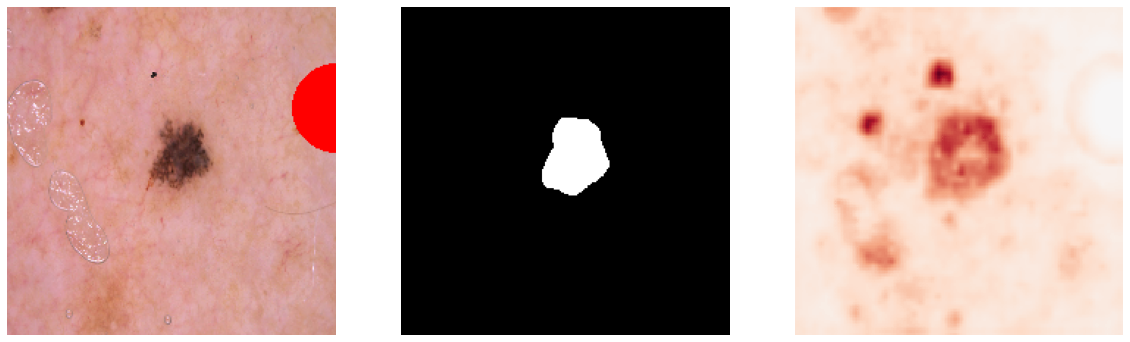

['false_neg', 'false_pos', 'true_neg', 'true_pos']
true_pos :
[4, 6, 8, 11, 15, 19, 24, 27, 35, 36, 37, 38, 39, 41, 47, 51, 52, 53, 58, 59, 60, 61, 62, 66, 67, 70, 71, 72, 79, 82, 83, 84, 88, 92, 95, 98, 99, 100, 103, 104, 107, 110, 114, 115, 116, 122, 123, 124, 125, 134]
false_neg :
[16, 23, 31, 32, 40, 42, 43, 50, 69, 76, 77, 80, 87, 96, 106, 117, 119, 126, 139, 143, 148, 150, 151, 153, 155, 168, 175, 178, 192, 196, 197, 199, 211, 214, 215, 219, 222, 225, 231, 238, 244, 256, 260, 269, 270, 271, 277, 278, 283, 293]
true_neg :
[0, 3, 7, 9, 13, 14, 17, 18, 20, 21, 22, 25, 26, 28, 29, 30, 33, 44, 45, 46, 48, 54, 55, 56, 63, 64, 65, 68, 73, 74, 78, 86, 89, 91, 93, 101, 113, 118, 120, 121, 128, 130, 131, 132, 133, 136, 140, 142, 149, 156, 157]
false_pos :
[1, 2, 5, 10, 12, 34, 49, 57, 75, 81, 85, 90, 94, 97, 102, 105, 108, 109, 111, 112, 127, 129, 135, 137, 138, 159, 161, 164, 171, 172, 174, 177, 179, 181, 189, 212, 213, 217, 221, 233, 234, 245, 248, 258, 267, 274, 285, 288, 303, 304, 311]

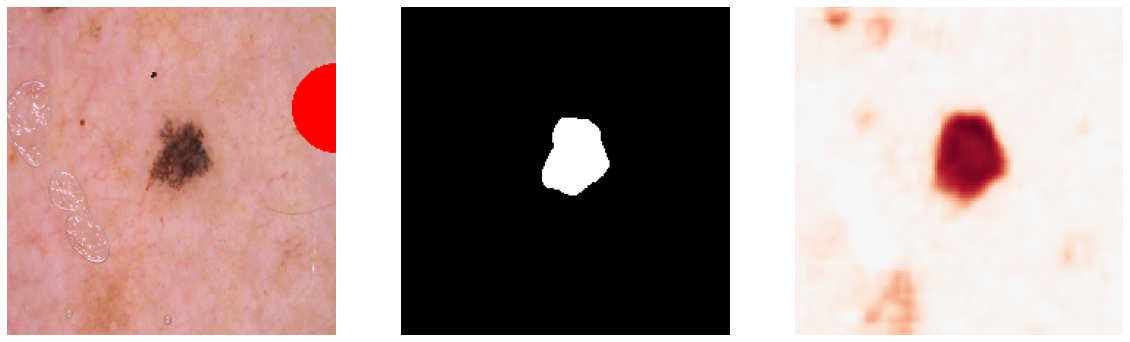

In [1]:
import os
import cv2
import sys
import h5py
import shutil
sys.path.append('utils')
import general
import seaborn
import datetime
import collections
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
%matplotlib inline

confusion = 'false_neg'
label_oppo = False
result = 'R_4_train'
    
# dirname_list = [
# # '2101211754-12_20210126052639256',
# # '2101211754-12_20210126053154743',
# # '2101211754-12_20210126053754969',
# # '2101211754-12_20210126054326771',
# # '2101211754-12_20210126055107181',
    
# # '2101211754-46_20210126233007596', # simple_grad
    
# # '2101211754-22_20210127014506637', # LRP
    
# # '2101211754-32_20210127014633857', # Grad-CAM
    
# '2101220755-221_20210130001323345',
# ]

# # path = './result'
# img_list = [72] # 70, 71, 72, 76
# # for RGB image data
# mean = [0.73464843, 0.53643549, 0.56078696]
# std = [0.16950775, 0.17333991, 0.19156029]






server_list = [
    'server_54',
    'server_58',
    'server_61',
    'server_62',
]
proj_name = os.path.basename(os.getcwd())

# 각 서버의 result_path들을 긁어모은다
remote_result_path_list = []
for server in server_list:
    result_dir_path = os.path.join('/home/juna', server, proj_name, 'result')
    if os.path.exists(result_dir_path):
        remote_result_path_list += [os.path.join(result_dir_path, path) for path in os.listdir(result_dir_path) if path[:1] == '2']
    else:
        print('No such directory : {}'.format(result_dir_path))
        pass
# print('remote_result_path_list :', remote_result_path_list)

# 현재 서버의 result_path도 얻는다.
path = './result'
result_path_list = [os.path.join(path, path) for path in os.listdir(path) if path[:1] == '2']

# 모든 서버의 result_path들에서 basename만 얻어낸다
result_path_basename_list = [os.path.basename(result_path) for result_path in result_path_list]
remote_result_path_basename_list = [os.path.basename(result_path) for result_path in remote_result_path_list]

# basename들에서 중복을 제거
all_result_path_basename_list = result_path_basename_list + remote_result_path_basename_list
all_result_path_basename_list_u = []
for basename in all_result_path_basename_list:
    if basename not in all_result_path_basename_list_u:
        all_result_path_basename_list_u.append(basename)

# 현재 서버에 존재하는 basename들은 현재 서버의 경로로 그렇지 않으면 존재하는 다른 서버의 경로로 지정해줌
# print('all_result_path_basename_list_u :', all_result_path_basename_list_u)
# print('remote_result_path_list :', remote_result_path_list)
print()
result_path_list = []
for basename in all_result_path_basename_list_u:
    if basename in result_path_basename_list:
        result_path_list.append(os.path.join('./result', basename))
    else:
#         print('remote basename :', basename)
        for path in remote_result_path_list:
            if basename in path:
                result_path_list.append(path)
                break
                
result_path_list.sort()


# for dir_num, dirname in enumerate(dirname_list):
#     dir_path = None
#     if dirname in result_path_basename_list:
#         dir_path = os.path.join('./result', dirname)
#     else:
# #         print('remote dirname :', dirname)
#         for remote_result_path in remote_result_path_list:
#             if dirname in remote_result_path:
#                 dir_path = remote_result_path
#                 break



# classifier
# simple_grad : 
#     2104171954-1_20210417202522166
# IG :
    
# SG :
    
# LRP :
#     2105050118-1_20210505025304655
# Grad-CAM :
#     2105050118-1_20210505021529831
#-----------------------------------------
# classifier
# simple_grad : 
#     2105061407-4_20210506154615310
# IG :
#     2105061407-1_20210506142801918
# SG :
#     2105061407-1_20210506143756150
# LRP :
#     2105061407-3_20210506142818161
# Grad-CAM :
#     2105061407-1_20210506144534693
    
# IR
# simple_grad : 
#     2104172027-1_20210417203344143
# IG :
#     2105041811-1_20210504182521923
# SG :
#     2105041406-1_20210504142239141
# LRP :
#     2104172142-1_20210418061612106
# Grad-CAM :
#     2104172206-1_20210418060738737
    

dirname_list = [
    
#     '2105061407-4_20210506154615310',
#     '2105061407-1_20210506142801918',
#     '2105061407-1_20210506143756150',
#     '2105061407-3_20210506142818161',
#     '2105061407-1_20210506144534693',
    
'2104172027-1_20210417203344143',
'2105041811-1_20210504182521923',
'2105041406-1_20210504142239141',
'2104172142-1_20210418061612106',
'2104172206-1_20210418060738737',

    

]

img_list = [67] # 70, 71, 72, 76
# for RGB image data
mean = [0.73464843, 0.53643549, 0.56078696]
std = [0.16950775, 0.17333991, 0.19156029]

for dir_num, dirname in enumerate(dirname_list):
    dir_path = None
    if dirname in result_path_basename_list:
        dir_path = os.path.join('./result', dirname)
    else:
#         print('remote dirname :', dirname)
        for remote_result_path in remote_result_path_list:
            if dirname in remote_result_path:
                dir_path = remote_result_path
                break
    with h5py.File(os.path.join(dir_path, 'IoU.hdf5'), 'r') as f:
        print(list(f.keys()))

        
        
        
        
        
        
        
        
        
        
        
# for dirname in dirname_list:
#     with h5py.File(os.path.join(path, dirname, 'IoU.hdf5'), 'r') as f:
#         print(list(f.keys()))

        img_dict = collections.OrderedDict()
        img_dict['true_pos'] = f['true_pos/ori/img_idx'][()] if 'true_pos/ori/img_idx' in f else np.array([[]])
        img_dict['false_neg'] = f['false_neg/ori/img_idx'][()] if 'false_neg/ori/img_idx' in f else np.array([[]])
        img_dict['true_neg'] = f['true_neg/ori/img_idx'][()] if 'true_neg/ori/img_idx' in f else np.array([[]])
        img_dict['false_pos'] = f['false_pos/ori/img_idx'][()] if 'false_pos/ori/img_idx' in f else np.array([[]])

        for key in list(img_dict.keys()):
            print('{} :\n{}'.format(key, list(img_dict[key][0:200])))
        print()

        print('################ Statistics ################')
        cof = []
        for cof_key in ['true_pos', 'false_neg', 'true_neg', 'false_pos']:
            if '{}/ori/img_idx'.format(cof_key) in f:
                cof.append(f['{}/ori/img_idx'.format(cof_key)].shape[0])
            else:
                cof.append(0)
        cof.append(sum(cof))
        print('true_pos {}/{}, false_neg {}/{}, true_neg {}/{}, false_pos {}/{}, sum {}'.format(
                cof[0], round(cof[0]/cof[4], 2),
                cof[1], round(cof[1]/cof[4], 2),
                cof[2], round(cof[2]/cof[4], 2),
                cof[3], round(cof[3]/cof[4], 2), cof[4]))

        for img_idx in img_list: # img_list = [1, 6, 34, ...] 보고 싶은 image의 번호
            print('============================ {} ============================'.format(img_idx))
            
            # 'true_pos', 'false_pos', 'true_neg', 'false_neg'을 돌면서 보고 싶은 image의 번호를 찾는다
            for key in list(img_dict.keys()): # key = 'true_pos' or 'true_pos' ...
                if img_idx in img_dict[key]: # img_idx = img number that I chose
                    idx = np.where(img_dict[key] == img_idx) # 몇번째에 원하는 img가 있는지 찾는다
                    
                    #################################################################
#                     img = f['{}/ori/img'.format(key)][list(idx[0])[0]][1] # CT image일 때, 첫번째 슬라이드만 visualize
                    img = f['{}/ori/img'.format(key)][list(idx[0])[0]] # RGB image일 때
                    #################################################################
                    mask = f['{}/ori/mask'.format(key)][list(idx[0])[0]][0]
                    R_4_IoU_ori = f['{}/ori/R_4_IoU'.format(key)][list(idx[0])[0]][0]
                    R_4_IoU_ori = skimage.transform.resize(R_4_IoU_ori, (224, 224))
                    R_4_train_ori = f['{}/ori/R_4_train'.format(key)][list(idx[0])[0]][0]
                    R_4_train_ori = skimage.transform.resize(R_4_train_ori, (224, 224))
                    
                    if label_oppo:
                        R_4_IoU_oppo = f['{}/oppo/R_4_IoU'.format(key)][list(idx[0])[0]][0]
                        R_4_IoU_oppo = skimage.transform.resize(R_4_IoU_oppo, (224, 224))
                        R_4_train_oppo = f['{}/oppo/R_4_train'.format(key)][list(idx[0])[0]][0]
                        R_4_train_oppo = skimage.transform.resize(R_4_train_oppo, (224, 224))


                    union, IS, IoU = None, None, None
                    if key in ['true_pos', 'false_neg']:
#                         union = f['{}/ori/union'.format(key)][list(idx[0])[0]][0]
#                         IS = f['{}/ori/IS'.format(key)][list(idx[0])[0]][0]
#                         IoU = f['{}/ori/IoU'.format(key)][list(idx[0])[0]]

                        print('key :', key)
#                         print('IoU :', IoU)
                        fig, ax = plt.subplots(nrows=1, ncols=5 if label_oppo else 3, figsize=(20, 20))
                        ########################################################################
#                         ax[0].imshow(np.clip(img, -224, 224), cmap='gray') # MSD dataset일 때
                        img = ((img.transpose(1, 2, 0)*std + mean)*255).astype(np.uint8)
                        ax[0].imshow(img) # RGB image일 때
                        ########################################################################
                        ax[0].axis('off')
                        ax[1].imshow(mask, cmap='gray')
                        ax[1].axis('off')
#                         print('pixel value :', R_4_IoU_ori[100, 100])
#                         pos_neg_map = (R_4_IoU_ori > 0)*1.0 - (R_4_IoU_ori < 0)*1.0
#                         R_4_IoU_ori = np.abs(R_4_IoU_ori*5)**(1.2) * pos_neg_map
                        seaborn.heatmap(R_4_IoU_ori, cmap='RdBu_r', center=0, ax=ax[2], square=True, cbar=False, cbar_kws={'shrink': .2})
#                         seaborn.heatmap(np.clip(R_4_IoU_ori, -4, 4), cmap='RdBu_r', center=0, ax=ax[2], square=True, cbar=False, cbar_kws={'shrink': .2})
                        ax[2].axis('off')
#                         seaborn.heatmap(R_4_train_ori, cmap='RdBu_r', center=0, ax=ax[3], square=True, cbar=False, cbar_kws={'shrink': .2})
#                         ax[3].axis('off')
                        if label_oppo:
                            seaborn.heatmap(R_4_IoU_oppo, cmap='RdBu_r', center=0, ax=ax[3], square=True, cbar=False, cbar_kws={'shrink': .2})
                            ax[3].axis('off')
                            
                            # heatmap 진하게 만들기
                            pos_neg_map = (R_4_train_oppo > 0)*1.0 - (R_4_train_oppo < 0)*1.0
                            R_4_train_oppo = np.abs(R_4_train_oppo*5)**(1.2) * pos_neg_map
                            seaborn.heatmap(np.clip(R_4_train_oppo, -1.5, 1.5), cmap='RdBu_r', center=0, ax=ax[4], square=True, cbar=False, cbar_kws={'shrink': .2})
                            # 일반 heatmap
#                             seaborn.heatmap(R_4_train_oppo, cmap='RdBu_r', center=0, ax=ax[4], square=True, cbar=False, cbar_kws={'shrink': .2})
                            ax[4].axis('off')
#                         ax[6 if label_oppo else 3].imshow(union, cmap='gray')
#                         ax[6 if label_oppo else 3].axis('off')
#                         ax[7 if label_oppo else 4].imshow(IS, cmap='gray')
#                         ax[7 if label_oppo else 4].axis('off')
                        plt.show()


                    else:
                        print('key :', key)
                        fig, ax = plt.subplots(nrows=1, ncols=4 if label_oppo else 3, figsize=(20, 20))
#                         ax[0].imshow(img, cmap='gray') # RGB image 아닐 때
                        ax[0].imshow(((img.transpose(1, 2, 0)*std + mean)*255).astype(np.uint8)) # RGB image 일 때
                        ax[0].axis('off')
                        ax[1].imshow(mask, cmap='gray')
                        ax[1].axis('off')
                        seaborn.heatmap(R_4_IoU_ori, cmap='RdBu_r', center=0, ax=ax[2], square=True, cbar=False, cbar_kws={'shrink': .2})
                        ax[2].axis('off')
                        if label_oppo:
                            seaborn.heatmap(R_4_IoU_oppo, cmap='RdBu_r', center=0, ax=ax[3], square=True, cbar=False, cbar_kws={'shrink': .2})
                            ax[3].axis('off')
                        plt.show()



# Diff types of interpretation

In [ ]:
import os
import sys
import h5py
sys.path.append('utils')
import general
import datetime
from pandas import ExcelWriter


path = './result'
df = general.result2dataframe(path, filter='interp')
sample_cond = {
    
}
df = general.get_df_sample(df, sample_cond)
priorities = ['model', 'dataset_class', 'interpreter', 'lrp_target_layer', 'val_func', 'result_path', 'ip', 'gpu', 'data_path', 'train_ratio', 'mask_ratio', 'min_tumor_size', 'epochs', 'batch_size', 'model_path']
df = general.dataframe_edit(df, priorities)
df.sort_values(by=['result_path'], inplace=True)

writer = ExcelWriter('plot_result.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

display(df)


# 성환형꺼랑 내꺼랑 interp 똑같이 나오나 확인

In [ ]:
import os
import sys
import h5py
import shutil
sys.path.append('utils')
import general
import seaborn
import datetime
import collections
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
%matplotlib inline

dirname_list = [
    'interp_20201116213252438',
#     'interp_20201116215219092',
#     'interp_20201116223527105',
]
path = './result'
comparison_path = '/home/juna/Fooling_Neural_Network-Interpretations/run_lrp/interpretation'




for dirname in dirname_list:
    # dirname가 어떤 interpreter를 사용했는지 알아냄 
    setting_dict = general.get_setting(os.path.join(path, dirname))
    interpreter = setting_dict['interpreter'][0]
    filename = 'interp-{}.hdf5' if 'grad_cam' in interpreter else 'interp-{}_T.hdf5'
    
    with h5py.File(os.path.join(path, dirname, 'interp.hdf5'), 'r') as f:
        with h5py.File(os.path.join(comparison_path, filename.format(interpreter)), 'r') as g:
            
            
            
            print(list(f.keys()))

            print(f['R'].shape)
            print(f['img'].shape)
            
            mean = np.array([0.485, 0.456, 0.406])[np.newaxis,np.newaxis,:]
            std = np.array([0.229, 0.224, 0.225])[np.newaxis,np.newaxis,:]
            for num in range(f['R'].shape[0]):
                R_1 = None
                R_2 = None
                fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))
                ax[0].imshow(np.transpose(f['img'][num], (1, 2, 0))*std + mean)
                if len(f['R'].shape) == 4:
                    R_1 = f['R'][num].sum(0)
                    ax[1].imshow(f['R'][num].sum(0), cmap='gray')
                else:
                    R_1 = f['R'][num]
                    ax[1].imshow(f['R'][num], cmap='gray')
                    
                ax[2].imshow(np.transpose(g['img'][num], (1, 2, 0))*std + mean)
                if len(g['R'].shape) == 4:
                    R_2 = g['R'][num].sum(0)
                    ax[3].imshow(g['R'][num].sum(0), cmap='gray')
                else:
                    R_2 = g['R'][num]
                    ax[3].imshow(g['R'][num], cmap='gray')
                plt.show()
            
                print('R_1 - R_2 :', (R_1 - R_2).sum())
                print()
                print()

#             print(list(g.keys()))
#             print(g['R'].shape)
#             print(g['img'].shape)

#             for num in range(g['R'].shape[0]):
#                 fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
#                 ax[0].imshow(np.transpose(g['img'][num], (1, 2, 0)))
#                 if len(g['R'].shape) == 4:
#                     ax[1].imshow(g['R'][num].sum(0), cmap='gray')
#                 else:
#                     ax[1].imshow(g['R'][num], cmap='gray')
#                 plt.show()
        